In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ipfx.dataset.create import create_ephys_data_set
import ipfx.script_utils as su
import ipfx.data_set_features as dsf
import ipfx.stimulus_protocol_analysis as spa
import ipfx.time_series_utils as tsu


In [4]:
nwb2_path = "/allen/programs/celltypes/workgroups/ivscc/nathang/cell_cards_ephys/nwb/000008/sub-mouse-PIDAD/sub-mouse-PIDAD_ses-20180720-sample-2_slice-20180720-slice-2_cell-20180720-sample-2_icephys.nwb"

In [5]:
data_set = create_ephys_data_set(nwb_file=nwb2_path, load_into_memory=False)

In [55]:

d = data_set.get_sweep_data(12)

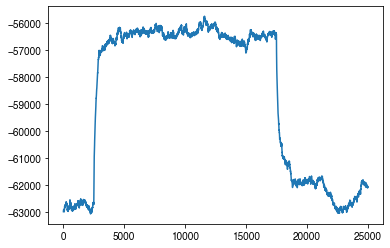

In [56]:
plt.plot(d["response"])

In [57]:
len(d["stimulus"])

22500

In [49]:
len(d["response"])

25000

In [50]:
good_sweep_numbers = []
for sn in data_set._data.sweep_numbers:
    try:
        d = data_set.get_sweep_data(sn)
        swp = data_set.sweep(sn, enforce_equal_length=False)
        good_sweep_numbers.append(sn)
    except:
        continue
    

Could not find stimulus: NA


In [51]:
good_sweep_numbers

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79]

In [52]:
for sn in good_sweep_numbers:
    d = data_set.get_sweep_data(sn)
    if len(d["stimulus"]) != len(d["response"]):
        print(sn, d)
        break

0 {'stimulus': array([-0., -0., -0., ..., -0., -0., -0.]), 'response': array([-63907.36997128, -63901.27539635, -63894.29420233, ...,
       -63844.39766407, -63835.44206619, -63829.25063372]), 'stimulus_unit': 'Amps', 'sampling_rate': 25000.0}


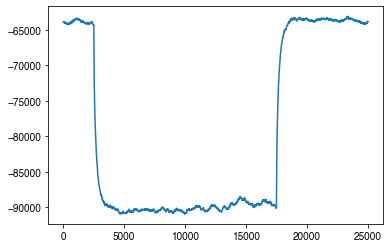

In [53]:
plt.plot(d["response"])
# plt.plot(d["stimulus"])

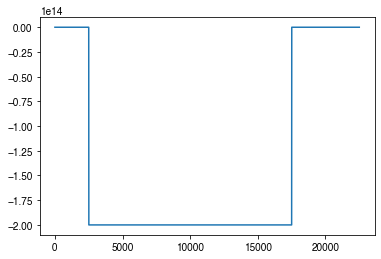

In [54]:
plt.plot(d["stimulus"])



In [44]:
def process_sweeps(data_set, sweep_numbers, subthresh_min_amp=-100):
    lsq_sweeps = data_set.sweep_set(sweep_numbers, enforce_equal_length=False)

    # Correct sweep amplitudes & lengths
    for swp in lsq_sweeps.sweeps:
        print(swp.sweep_number)
        swp._i = swp._i * 1e-12
        swp._v = swp._v * 1e-3
        
        min_len = min(len(swp._i), len(swp._v))
        swp._i = swp._i[:min_len]
        swp._v = swp._v[:min_len]

    
    # get timing from first sweep
    swp = lsq_sweeps.sweeps[0]

    # Determine the sweep amplitude
    min_i = np.min(swp.i)
    max_i = np.max(swp.i)
    if min_i < 0:
        stim_amp = min_i
    else:
        stim_amp = max_i

    # Determine the start and end of the sweep
    at_amp_ind = np.flatnonzero(swp.i == stim_amp)
    start_ind = at_amp_ind[0]
    lsq_start = swp.t[at_amp_ind[0]]
    lsq_end = swp.t[at_amp_ind[-1]]
    
    lsq_spx, lsq_spfx = dsf.extractors_for_sweeps(
        lsq_sweeps,
        start=lsq_start,
        end=lsq_end,
        min_peak=-25,
        **dsf.detection_parameters(data_set.LONG_SQUARE)
    )
        
    lsq_an = spa.LongSquareAnalysis(lsq_spx, lsq_spfx,
        subthresh_min_amp=subthresh_min_amp)
    lsq_features = lsq_an.analyze(lsq_sweeps)

    subthresh_numbers = lsq_features["subthreshold_membrane_property_sweeps"].index.tolist()
    
    
    rheo_number = lsq_features["rheobase_sweep"].name
    rheo_amp = lsq_features["rheobase_i"]
    
    rheo_swp = lsq_sweeps.sweeps[rheo_number]
    print(rheo_swp.sweep_number)

    
    print(rheo_number, rheo_amp)
    
    spiking_df = lsq_features["spiking_sweeps"]
    print(spiking_df)
    rheo_plus_80_number = spiking_df.loc[spiking_df["stim_amp"] == rheo_amp + 80, :].index.tolist()[0]
    print(rheo_plus_80_number)
    
    fig, axes = plt.subplots(1, 2, gridspec_kw={"width_ratios": (1, 2),  "wspace":0.05})
    for sn in subthresh_numbers:
        swp = lsq_sweeps.sweeps[sn]
        axes[1].plot(swp.t, swp.v, c="black", lw=0.5)
                
    swp = lsq_sweeps.sweeps[rheo_number]
    axes[1].plot(swp.t, swp.v, c="black", lw=0.5)

    print(lsq_features["spikes_set"][rheo_number]["threshold_index"][0])
    spike_start = lsq_features["spikes_set"][rheo_number]["threshold_t"][0]
    spike_end = spike_start + 0.005
    spike_start_ind = tsu.find_time_index(swp.t, spike_start)
    spike_end_ind = tsu.find_time_index(swp.t, spike_end)
    axes[0].plot(swp.t[spike_start_ind:spike_end_ind] - spike_start, swp.v[spike_start_ind:spike_end_ind])
    

    swp = lsq_sweeps.sweeps[rheo_plus_80_number]
    axes[1].plot(swp.t, swp.v + 120, c="black", lw=0.5)

    axes[0].set_ylim(-120, 60)
    axes[0].set(yticks=[], xticks=[])
    axes[1].set_ylim(-150, 200)
    axes[1].set(yticks=[], xticks=[])

    sns.despine(left=True, bottom=True)
#     rheo_spikes = lsq_features
    
#     spike_wf = 

In [45]:
process_sweeps(data_set, good_sweep_numbers, subthresh_min_amp=-200)

Could not find stimulus: NA


0
1
2
3
4
5
6
7
8
9
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
11
10 20.0
     avg_rate                 peak_deflect  stim_amp  v_baseline        sag  \
7    3.333556  (-70.60369104146957, 12944)     -60.0  -62.753127   0.224334   
10   3.333556   (30.993124470114708, 7135)      20.0  -62.357787 -24.775575   
17   1.666778    (37.37761080265045, 3153)     160.0  -62.207523  -5.381582   
18   5.000333    (36.85078024864197, 2969)     180.0  -62.848594  -4.806801   
19   5.000333    (37.45719790458679, 2951)     200.0  -63.545990  -4.652673   
20   3.333556    (38.96664083003998, 2810)     220.0  -62.974570  -4.231938   
21   6.667111   (39.305318146944046, 2777)     240.0  -63.492109  -3.906232   
22   5.000333    (38.71959447860718, 2785)     260.0  -63.891542  -4.291326   
23   5.000333   (39.240140467882156, 2798)     280.

IndexError: list index out of range

In [24]:
rheo_num = None
rheo_amp = -np.inf

for sn in data_set._data.sweep_numbers:
    print(sn)
    try:
        d = data_set.get_sweep_data(sn)
        v = d["response"] * 1e-3 # mV
        i = d["stimulus"] * 1e-12 # pA
        t = np.arange(len(v)) * (1 / d["sampling_rate"]) # seconds
        
        # Determine the sweep amplitude
        min_i = np.min(i)
        max_i = np.max(i)
        if min_i < 0:
            stim_amp = min_i
        else:
            stim_amp = max_i
        
        # Determine the start and end of the sweep
        at_amp_ind = np.flatnonzero(i == stim_amp)
        start_time = t[at_amp_ind[0]]
        end_time = t[at_amp_ind[-1]]
        
        
        
    except:
        continue

0
2500 17499


In [85]:
lsq_sweeps = data_set.sweep_set(good_sweep_numbers)

Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimulus: NA
Could not find stimu

In [88]:
# Correct sweep units
for swp in lsq_sweeps.sweeps:
    swp._i = swp._i * 1e-12
    swp._v = swp._v * 1e-3

swp = lsq_sweeps.sweeps[0]

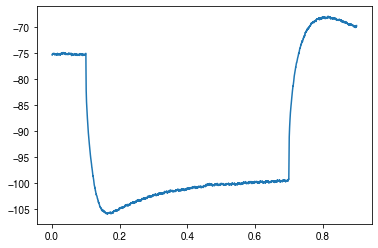

In [89]:
plt.plot(swp.t, swp.v)

In [90]:
# Determine the sweep amplitude
min_i = np.min(swp.i)
max_i = np.max(swp.i)
if min_i < 0:
    stim_amp = min_i
else:
    stim_amp = max_i

# Determine the start and end of the sweep
at_amp_ind = np.flatnonzero(swp.i == stim_amp)
start_ind = at_amp_ind[0]
lsq_start = swp.t[at_amp_ind[0]]
lsq_end = swp.t[at_amp_ind[-1]]

lsq_spx, lsq_spfx = dsf.extractors_for_sweeps(
    lsq_sweeps,
    start=lsq_start,
    end=lsq_end,
    min_peak=-25,
    **dsf.detection_parameters(data_set.LONG_SQUARE)
)

In [119]:
swp = lsq_sweeps.sweeps[14]

15 100.0


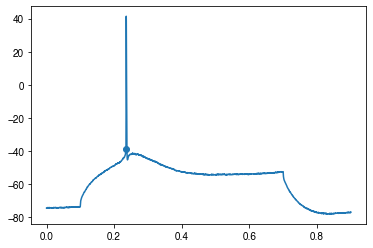

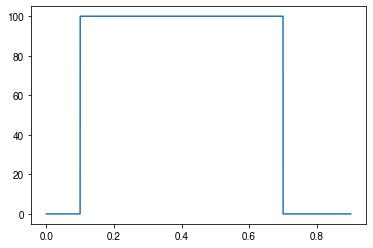

In [120]:
print(swp.sweep_number, np.max(swp.i))
plt.plot(swp.t, swp.v)
res = lsq_spx.process(swp.t, swp.v, swp.i)
plt.scatter(res["threshold_t"], res["threshold_v"])
plt.figure()
plt.plot(swp.t, swp.i)

In [ ]:
lsq_spx.process(swp.t, swp.v, swp.i)